# COGS 516 - BART Introduction

The Balloon Analogue Risk Task (BART) is widely-used to measure risk propensity. Participants are shown a balloon on a computer screen which they can pump with a keypress to increase their reward. But, there's a risk of balloon bursting (leading to loss of the reward). So, they need to bank (cash-in) to increase the total reward.

Firstly familiarise yourself with BART:

- Try BART yourself [here](https://www.unipark.de/uc/testothek/?a=bart)
- More information about BART is available [here](http://www.impulsivity.org/measurement/bart/)

The data for this assignment is from an experiment where researchers were interested in the effects of alcohol consumption on risk taking. The experiment was a within-subjects design, where each participant were administered three different doses of alcohol before they're presented with BART. There were also three different probabilities for balloon bursts in three different blocks which consisted of 30 trials each. These blocks were given in random order, and subjects were informed about the burst probability values prior to each block. The gain with each pump was a percentage of the money gained so far.

Design of the experiment:
[3 sessions: sober, tipsy, drunk] x [3 blocks for p_burst: 0.1, 0.15, 0.2] x [30 trials]

The data from the experiment is given in a folder consisting of `name-id.txt` files. The session-condition relation seems to be randomized, and authors share a mapping matrix (given below). Assume that participant ID is given after sorting names alphabetically (i.e. Frank is the first subject, Gjis is the second, up to Wouter, the last). Condition identifier matrix is given below `condition_info`. According to this matrix for participant 1, session 1 was the drunk condition, session 2 was the tipsy condition, and session 3 was the sober condition (i.e. columns for participants 1 to 18, and rows for session 1 to 3, and values are 1: sober, 2: tipsy, 3: drunk). So, for 3rd participant 1st session was tipsy, 2nd session was drunk and 3rd session was sober.

**Note:** It's almost necessary that you familiarize yourselves with tidy-data principles. See the notebook provided for that. Consult it for examples of data manipulation and corresponding `pandas` methods.

**Note:** It's advised that you use `seaborn` for data visualization. You're also allowed to use `matplotlib`, if you like. There's a short seaborn introduction provided in another notebook.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
condition_info = np.array([[3, 1, 2, 2, 1, 3, 2, 3, 1, 2, 2, 3, 2, 1, 1, 1, 3, 3],
                         [2, 2, 3, 3, 3, 1, 1, 2, 2, 1, 1, 1, 3, 3, 2, 3, 2, 1],
                         [1, 3, 1, 1, 2, 2, 3, 1, 3, 3, 3, 2, 1, 2, 3, 2, 1, 2]])
condition_info

array([[3, 1, 2, 2, 1, 3, 2, 3, 1, 2, 2, 3, 2, 1, 1, 1, 3, 3],
       [2, 2, 3, 3, 3, 1, 1, 2, 2, 1, 1, 1, 3, 3, 2, 3, 2, 1],
       [1, 3, 1, 1, 2, 2, 3, 1, 3, 3, 3, 2, 1, 2, 3, 2, 1, 2]])

## Part 1 (50 pts)

**TASK 1 (5 pts):** Read data into **tidy format**. We're interested in keeping a participant ID, alcohol condition, burst probability, trial number, number of pumps in a trial, cash-in amount, and total amount. You can discard other data columns.

*Hint:* If you use `glob` library to read files in a directory you can wrap your `glob.glob()` call in a `sorted()` to sort them alphabetically.


In [ ]:
import glob

files = sorted(glob.glob("/content/*.txt"))

tidy_data = pd.DataFrame(columns=['participant', 'condition', 'p_burst', 'trial', 'pumps', 'total', 'session'])

participanti = 0

dfs = []

for file in files:

    data = pd.read_csv(file, sep='\t', skiprows=1, names=['pres.bl', 'block', 'gr.fact', 'prob.', 'trial', 'pumps', 'cash', 'total'])

    # session
    session = int(file.split('_')[1].split('.')[0]) - 1

    # participant
    participant = (participanti) // 3

    # condition
    condition = condition_info[session, participant]

    if condition == 1:
      condition = 'sober'
    elif condition == 2:
      condition = 'tipsy'
    elif condition == 3:
      condition = 'drunk'

    # p_burst
    block = data['block']
    p_burst = [10 if i == 1 else (15 if i == 2 else (20 if i == 3 else None)) for i in block]

    df = pd.DataFrame({
        'participant': participant + 1,
        'condition': condition,
        'p_burst': p_burst,
        'trial': data['trial'],
        'pumps': data['pumps'],
        'cash': data['cash'],
        'total': data['total'],
        'session': session + 1
    })

    dfs.append(df)

    participanti += 1

# Concatenate all dataframes into one
final_df = pd.concat(dfs, ignore_index=True)

# Display the resulting dataframe
final_df.sample(n=10)

,participant,condition,p_burst,trial,pumps,cash,total,session
1492,6,sober,10,23,1,0.50,10.29,2
2276,9,tipsy,10,27,1,0.00,9.96,2
933,4,drunk,10,4,7,0.96,3.84,2
3512,14,sober,15,3,4,0.81,1.76,1
2756,11,tipsy,15,27,7,1.32,14.90,1
985,4,drunk,15,26,2,0.00,11.20,2
3171,12,tipsy,15,22,1,0.50,10.92,3
84,1,drunk,10,25,3,0.00,11.33,1
2789,11,tipsy,10,30,4,0.00,14.32,1
4333,17,drunk,20,14,5,0.00,9.84,1


**TASK 2 (5 pts):** Select a random subject and use `pandas.groupby` to see if you can count equal number of trials for each possible experimental setting. In other words, try to see all possible combinations of different values of independent variables, and count how many samples each contain for variable `pumps` (number of pumps).

Here, other than the indentity od each participant, there are 2z elements that effect the participants' choices: their condition when answering the survey, and their knowledge of the probability of each baloon bursting. Both of which are independent from each other (the condition of participant does not effect the probability of each baloon bursting, same is true for the reverse). So, I will take `p_burst`, `condition`, and `participant` to be independent variables that could effect the number of `pumps`.

In [325]:
random_participant = final_df['participant'].sample().iloc[0]

participant_data = final_df[final_df['participant'] == random_participant]

trial_counts = participant_data.groupby(['p_burst', 'condition'])['pumps'].sum().reset_index()

print("Trial counts for participant", random_participant, ":\n", trial_counts)

Trial counts for participant 2 :
    p_burst condition  pumps
0       10     drunk    111
1       10     sober    190
2       10     tipsy    111
3       15     drunk     84
4       15     sober    113
5       15     tipsy     87
6       20     drunk     75
7       20     sober     73
8       20     tipsy     88


In [326]:
subject_data = final_df[final_df['participant'] == random_subject]

counts1 = subject_data.groupby(['condition',	'pumps']).size().reset_index(name='count')
wide1 = counts1.pivot(index="condition", columns="pumps", values="count")

counts2 = subject_data.groupby(['p_burst',	'pumps']).size().reset_index(name='count')
wide2 = counts2.pivot(index="p_burst", columns="pumps", values="count")

# Display the result
print(wide1)
print(wide2)


pumps        1     2     3     4     5     6    7    8    9    10   11   12  \
condition                                                                     
drunk      24.0   9.0  12.0  11.0  14.0  10.0  2.0  1.0  NaN  1.0  2.0  1.0   
sober      22.0  11.0  11.0   8.0   7.0  15.0  4.0  6.0  5.0  NaN  1.0  NaN   
tipsy      11.0   9.0  11.0  15.0  12.0  12.0  8.0  6.0  2.0  2.0  1.0  NaN   

pumps       13   14   15  
condition                 
drunk      1.0  1.0  1.0  
sober      NaN  NaN  NaN  
tipsy      1.0  NaN  NaN  
pumps      1     2     3     4     5     6    7     8    9    10   11   12  \
p_burst                                                                      
10       16.0   6.0  10.0  12.0   6.0  12.0  8.0  10.0  5.0  1.0  2.0  1.0   
15       16.0  12.0  11.0   9.0  11.0  18.0  4.0   1.0  2.0  2.0  1.0  NaN   
20       25.0  11.0  13.0  13.0  16.0   7.0  2.0   2.0  NaN  NaN  1.0  NaN   

pumps     13   14   15  
p_burst                 
10       NaN  1.0  NaN  
15 

In [327]:
counts = subject_data.groupby(['condition', 'p_burst',	'pumps']).size().reset_index(name='count')

In [328]:
print('when sober:')
counts[counts["condition"] == 'sober'].pivot(index="p_burst", columns="pumps", values="count")

when sober:


pumps,1,2,3,4,5,6,7,8,9,11
p_burst,,,,,,,,,,
10,5.0,2.0,1.0,5.0,1.0,6.0,1.0,4.0,4.0,1.0
15,4.0,6.0,7.0,2.0,1.0,7.0,1.0,1.0,1.0,NaN
20,13.0,3.0,3.0,1.0,5.0,2.0,2.0,1.0,NaN,NaN


In [329]:
print('when tipsy:')
counts[counts["condition"] == 'tipsy'].pivot(index="p_burst", columns="pumps", values="count")

when tipsy:


pumps,1,2,3,4,5,6,7,8,9,10,11,13
p_burst,,,,,,,,,,,,
10,3.0,1.0,2.0,5.0,2.0,3.0,6.0,6.0,1.0,1.0,NaN,NaN
15,3.0,2.0,2.0,3.0,6.0,8.0,2.0,NaN,1.0,1.0,1.0,1.0
20,5.0,6.0,7.0,7.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [330]:
print('when drunk:')
counts[counts["condition"] == 'drunk'].pivot(index="p_burst", columns="pumps", values="count")

when drunk:


pumps,1,2,3,4,5,6,7,8,10,11,12,13,14,15
p_burst,,,,,,,,,,,,,,
10,8.0,3.0,7.0,2.0,3.0,3.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN
15,9.0,4.0,2.0,4.0,4.0,3.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0
20,7.0,2.0,3.0,5.0,7.0,4.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN


**TASK 3 (5 pts):** Find the maximum number of pumps, again for all combinations of independent variables: for each participant, condition, and burst probability. You can create three subplots in a row for each burst probability, put number of pumps to y-axis and participants to x-axis, and use hue for marking the condition. There are more than one way to do this:
- you can use `groupby` and use `catplot` without a `kind` argument
- you can use the non-`groupby`-ed `DataFrame`, and give `kind='point'` with `estimator='max'` as arguments to `catplot`

I will plot 2 versions for later analysis: with error bar and without errorbar

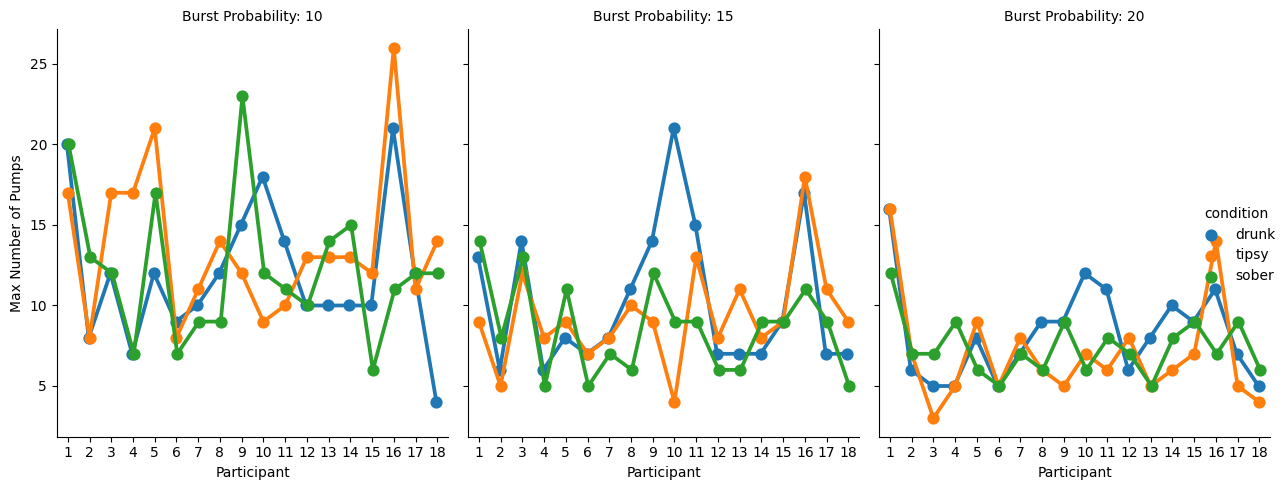

In [ ]:
g = sns.catplot(data=final_df, x='participant', y='pumps', hue='condition', col='p_burst',
                kind='point', estimator='max', dodge=True, aspect=0.8, errorbar=None,
                hue_order=['drunk', 'tipsy', 'sober'])

g.set_axis_labels('Participant', 'Max Number of Pumps')
g.set_titles('Burst Probability: {col_name}')

plt.tight_layout()

plt.show()

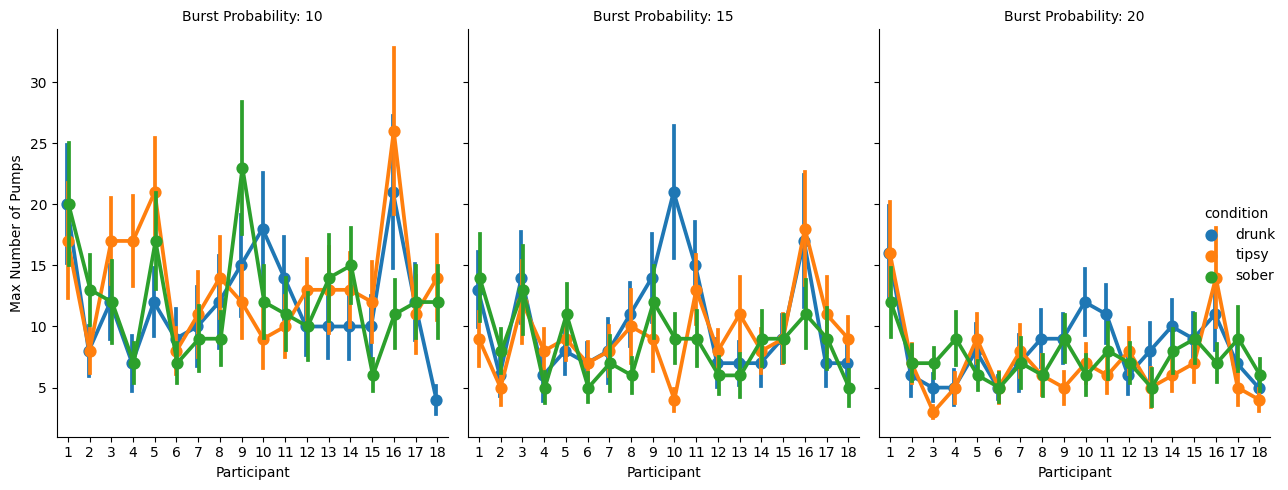

In [ ]:
g = sns.catplot(data=final_df, x='participant', y='pumps', hue='condition', col='p_burst',
                kind='point', estimator='max', dodge=True, aspect=0.8, errorbar='sd',
                hue_order=['drunk', 'tipsy', 'sober'])

g.set_axis_labels('Participant', 'Max Number of Pumps')
g.set_titles('Burst Probability: {col_name}')

plt.tight_layout()

plt.show()

**TASK 4 (5 pts):** What about mean number of pumps? Make the same plot, but with mean number of pumps as the dependent variable. You can use `errorbar` argument for `catplot` to draw a measure of dispersion (e.g. 'sd' for standard deviation).

Similar to previous section, I will plot 2 versions

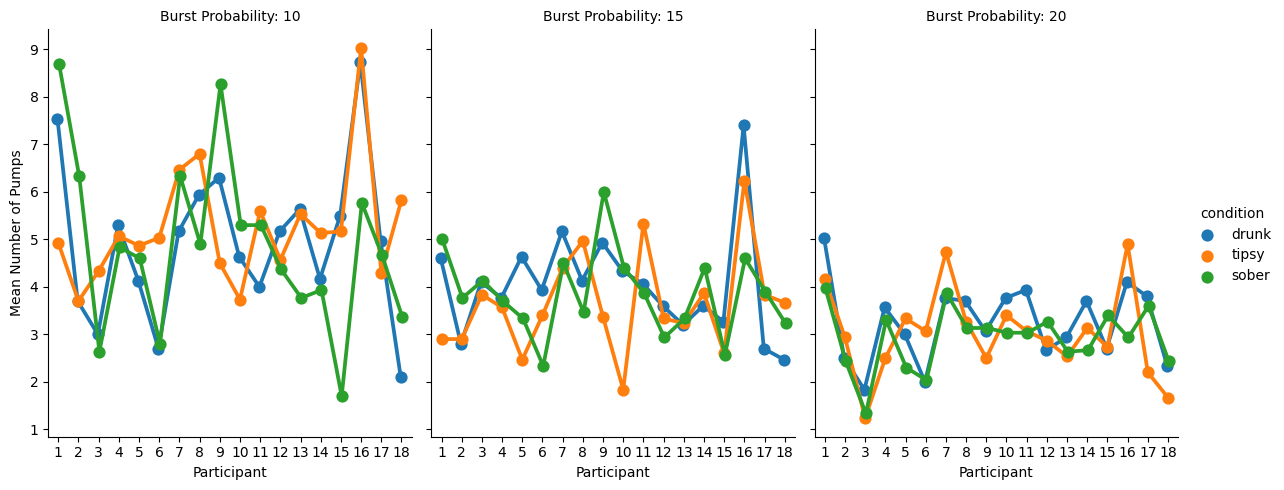

In [ ]:
g = sns.catplot(data=final_df, x='participant', y='pumps', hue='condition', col='p_burst',
                kind='point', estimator='mean', dodge=True, aspect=0.8, errorbar=None,
                hue_order=['drunk', 'tipsy', 'sober'])

g.set_axis_labels('Participant', 'Mean Number of Pumps')
g.set_titles('Burst Probability: {col_name}')
plt.show()

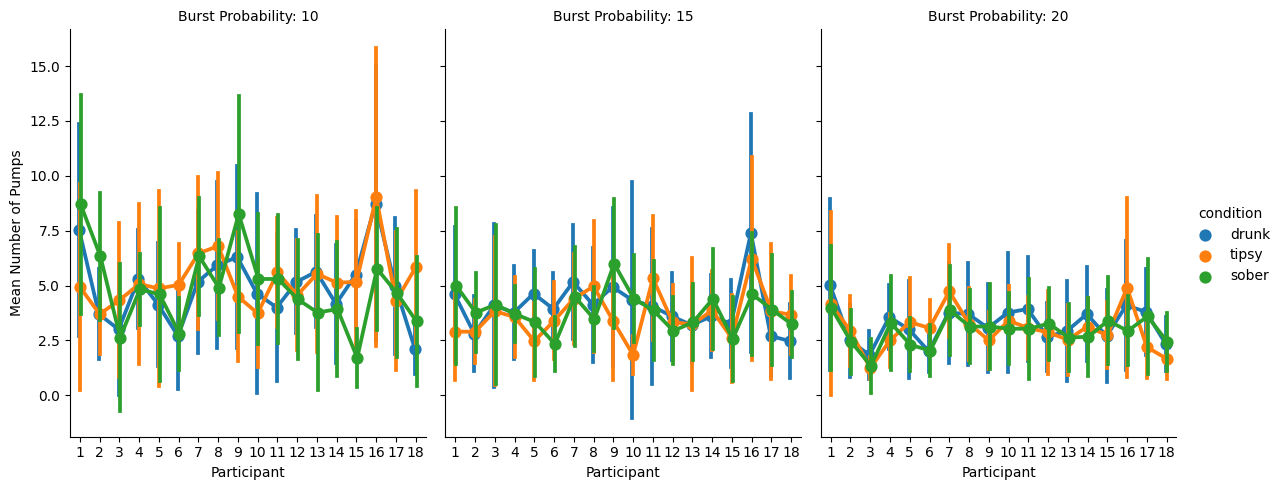

In [ ]:
g = sns.catplot(data=final_df, x='participant', y='pumps', hue='condition', col='p_burst',
                kind='point', estimator='mean', dodge=True, aspect=0.8, errorbar='sd',
                hue_order=['drunk', 'tipsy', 'sober'])

g.set_axis_labels('Participant', 'Mean Number of Pumps')
g.set_titles('Burst Probability: {col_name}')
plt.show()

**TASK 5 (5 pts):** What is the grand mean of number of pumps (across participants)? Plot two different views of the same data that shows burst probability, number of pumps, and conditions. To do this you can change, for example, the variable that you use for hue with another independent variable. The choice is up to you.

I will plot 2 types of plot:
  1. line plot
  2. bar plot

In [ ]:
grand_mean_pumps = final_df['pumps'].mean()
print("Grand Mean of Number of Pumps: {:.2f}".format(grand_mean_pumps))

Grand Mean of Number of Pumps: 3.97


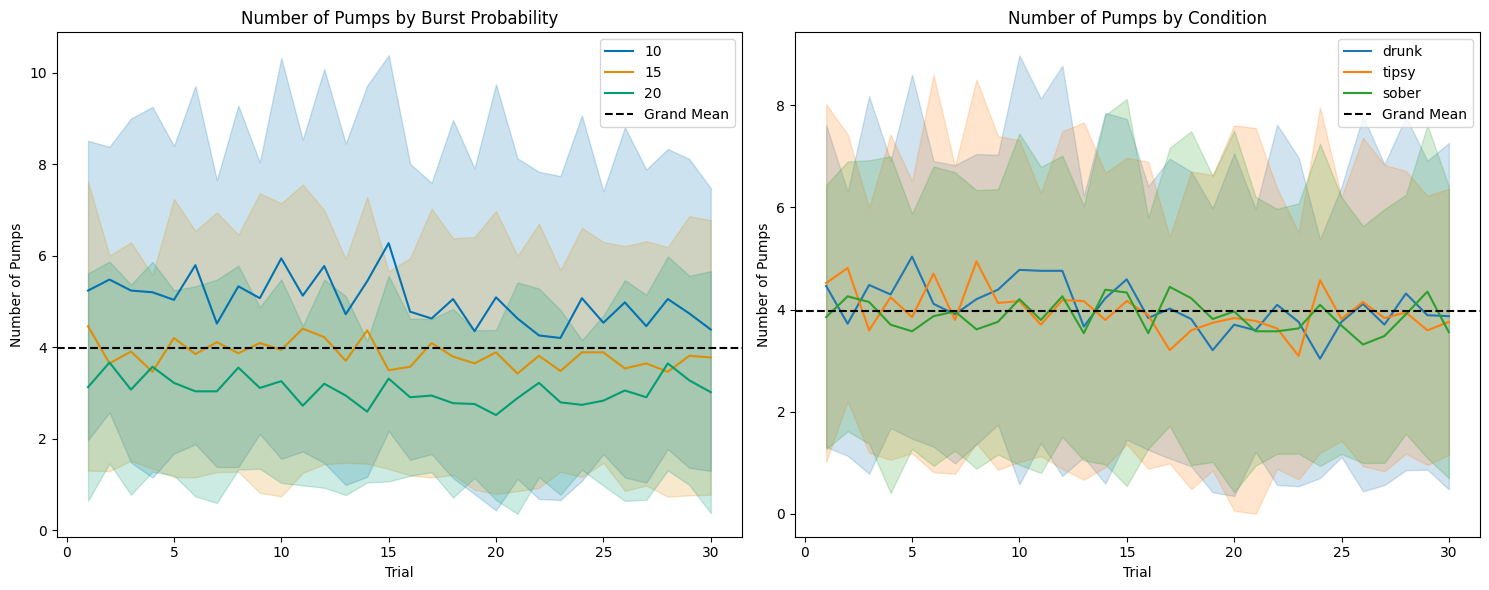

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=final_df, x='trial', y='pumps', hue='p_burst', errorbar='sd', palette='colorblind', ax=axes[0])
axes[0].axhline(y=grand_mean_pumps, color='black', linestyle='--', label='Grand Mean')
axes[0].set_title('Number of Pumps by Burst Probability')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Number of Pumps')
axes[0].legend()

sns.lineplot(data=final_df, x='trial', y='pumps', hue='condition', errorbar='sd', ax=axes[1])
axes[1].axhline(y=grand_mean_pumps, color='black', linestyle='--', label='Grand Mean')
axes[1].set_title('Number of Pumps by Condition')
axes[1].set_xlabel('Trial')
axes[1].set_ylabel('Number of Pumps')
axes[1].legend()

plt.tight_layout()
plt.show()


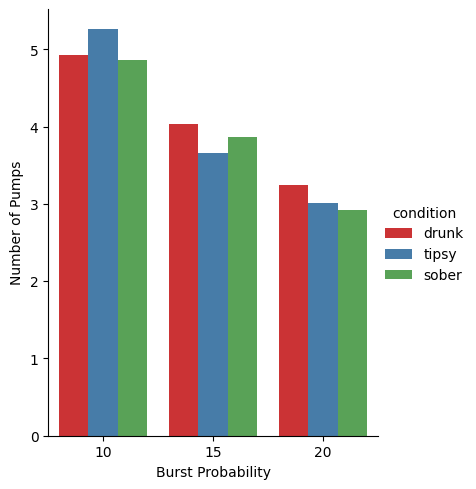

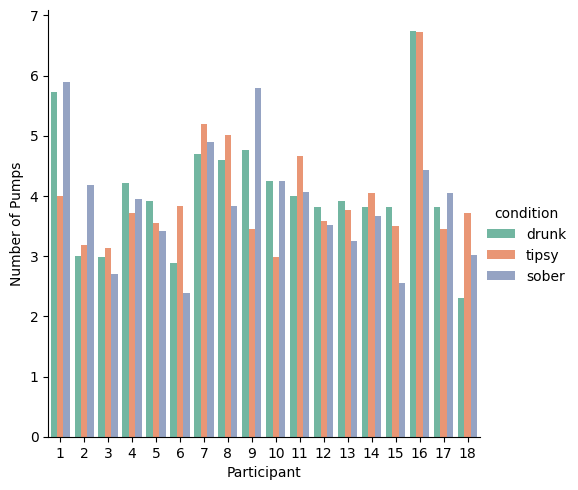

In [ ]:
g1 = sns.catplot(data=final_df, x='p_burst', y='pumps', hue='condition', kind='bar', palette='Set1', errorbar=None, aspect = 0.8)
g1.set_axis_labels('Burst Probability', 'Number of Pumps')
plt.show()

g2 = sns.catplot(data=final_df, x='participant', y='pumps', hue='condition', kind='bar', palette='Set2', errorbar=None)
g2.set_axis_labels('Participant', 'Number of Pumps')
plt.show()


**TASK 6 (5 pts):** Comment on the effect of independent variables on the dependent variable, number of pumps. Formal tests are not required, just comment on trends you see.


In task 2 we can observe that as p_burst increases, the number of pumps also decrease. For the random participant we have chosen (participant 2) we can observe that there is an interesting trend for different condition. Basically, the maximum number of pumps seems to increase as the participant goes from sober to tipsy to drunk. Although, the analysis in the following show different reults. So I want to note here that in task 1, it could be seen that participant 2 session 1 is sober, session 2 is tipsy, and session 3 is drunk. Which moves in an orderly manner. This is not so for many other participants which might cause problems is evaluating the direct effect of condition on pumps.

In task 3 and task 4, one interesting observation is the that maximum and mean pump peaks at 16 for both drunk and tipsy conditions, regardless of the probability of bursting. While, it could be seen that the value of the peak keeps decreasing as probability of bust increases.

Based on task 3 and task 4 plots, we can observe that at the points that pump numbers reaches a local (or global) peak, the value of pumps of tipsy is on a higher value compared to drunk condition. Although, we can observe in task 5 that, in general, the number of pumps is highly dependent on the p_burst value because, in average, in every single trial the value of pumps decreases as p_burst increases.

On the other hand, in the second line plot (the one in the right) task 5, we can observe that, similar to task 3 and 4, the condition of participants doesn’t seem to affect the number of pumps that much (especially for drunk and tipsy conditions). This is reltively unexpected and it either means that, unlike what many might assume, the number of pumps does not receive much affect from the condition of participant, or that, there exists a third factor hidden here that causes this to happen (such as the effect of the order of sessions, which effects the experience of each person with the BART task. This might effect how the participant decides to answer questions next time, regardless of his/her conditio). For further analysis, I will address this issue in task 11.

The next barplot also confirms our previous results about the total effect of condition on the number of pumps. Another noteworthy observation is that unlike when p_burst is 0.15 or 0.2, when p_burst = 0.1, tispy condition has the highest number of pumps.

Also, we can see that while the last barplot shows us that some participants seem to get much bigger risks when they are drunk or tipsy compared to sober (like participant 16). While some participants seem to show the exact opposite behavior like participant 9).


**TASK 7 (5 pts):** Up to now we did not separate pumps that lead to explosions. Now separate the dataset into two, one with and the other without explosions. *Hint:* `cash` value is 0 for exploding trials, and you can add a conditional to your list of variables of grouping that you input in `groupby`. In other words we're grouping with an additional binary categorical variable. So, we expect `n_participant` x `n_condition` x `n_burst` x `2` number of rows for a point estimate (e.g. mean) from number of pumps: $18*3*3*2 = 324$ rows. Go ahead and plot mean number of pumps across participants, as you did in **TASK 5**, but now stratify for trials with explosions, leading to $3*3*2 = 18$ values. You can use `col` argument to plot cash and explosion data (9 points each) side by side.

In [ ]:
final_df['exploded'] = final_df['cash'] == 0

mean_pumps_explosion = final_df.groupby(['participant', 'condition', 'p_burst', 'exploded'])['pumps'].mean().reset_index()

mean_pumps_explosion_for_plot = final_df.groupby(['p_burst', 'condition', 'exploded'])['pumps'].mean().reset_index()

print(len(mean_pumps_explosion))  # 18∗3∗3∗2=324
print(len(mean_pumps_explosion_for_plot)) # 3∗3∗2=18

324
18


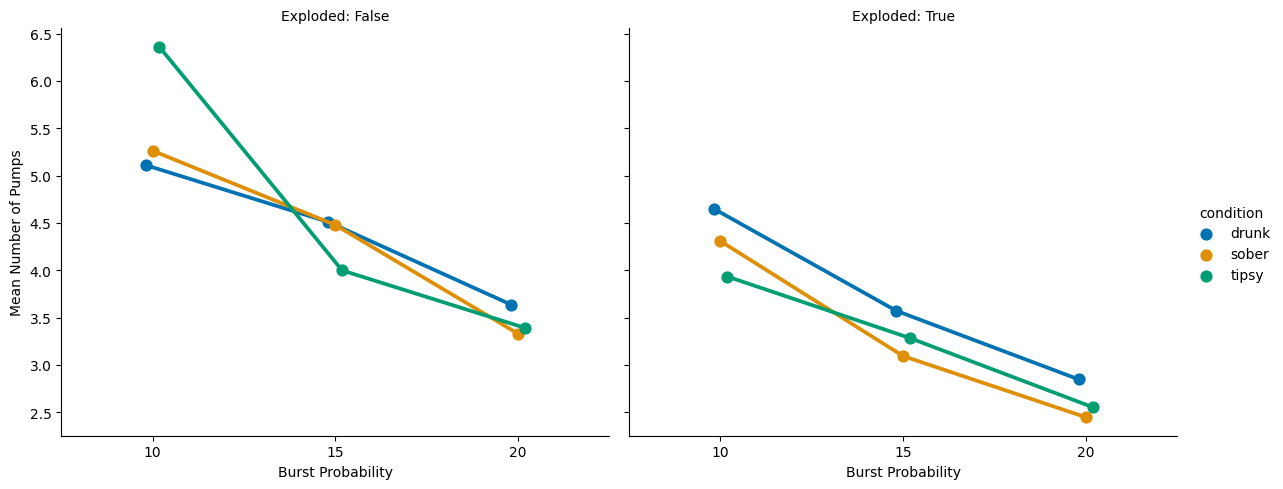

In [ ]:
g = sns.catplot(
    data=mean_pumps_explosion_for_plot,
    x='p_burst',
    y='pumps',
    hue='condition',
    col='exploded',
    kind='point',
    dodge=True,
    aspect=1.2,
    palette='colorblind'
)

g.set_axis_labels('Burst Probability', 'Mean Number of Pumps')
g.set_titles('Exploded: {col_name}')
plt.show()

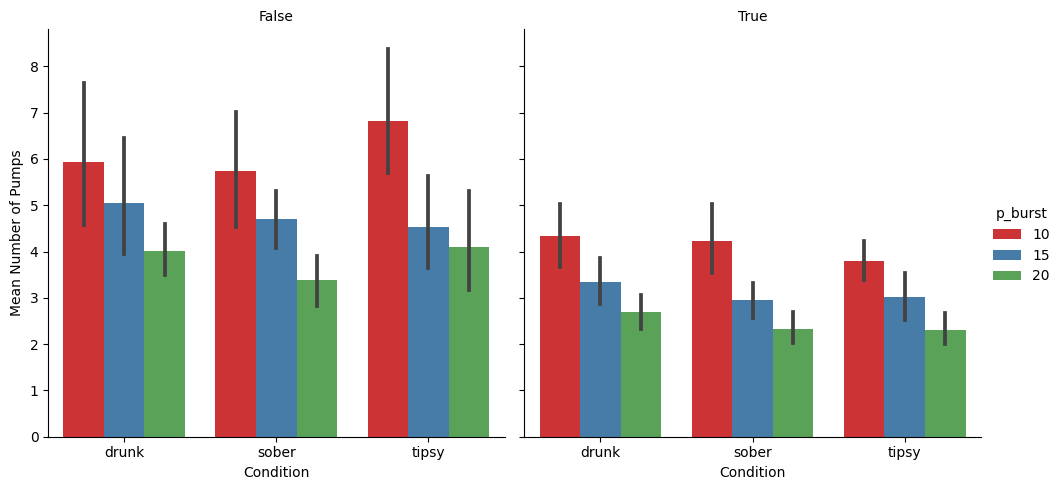

In [ ]:
g = sns.catplot(data=mean_pumps_explosion, x='condition', y='pumps', hue='p_burst', col='exploded', kind='bar', palette='Set1')
g.set_axis_labels('Condition', 'Mean Number of Pumps')
g.set_titles(col_template="{col_name}")
plt.show()

**TASK 8 (5 pts):** For each `participant` x `condition` x `p_burst` there's a pattern of `total` reward. It starts with 0, and monotonically increase. What are the characteristic evolution of total rewards for `condition` x `p_burst`, averaged across participants? An example for first five participants in drunk condition with 0.15 burst probability is given below. *Hint:* use seaborn's [`relplot`](https://seaborn.pydata.org/generated/seaborn.relplot.html) with `kind='line'`. You can use `col`, `hue` or `style` to further investigate categorical stratifications. With your plots, try to show that trial-score patterns are almost the same.

I will plot in 3 ways, once I plot by taking average for each participant seperatey, then I take overal average switching p_burst and condition in hue and col. We can see bellow that.

At the end we can easily observe that the trial-error average patterns are very similar

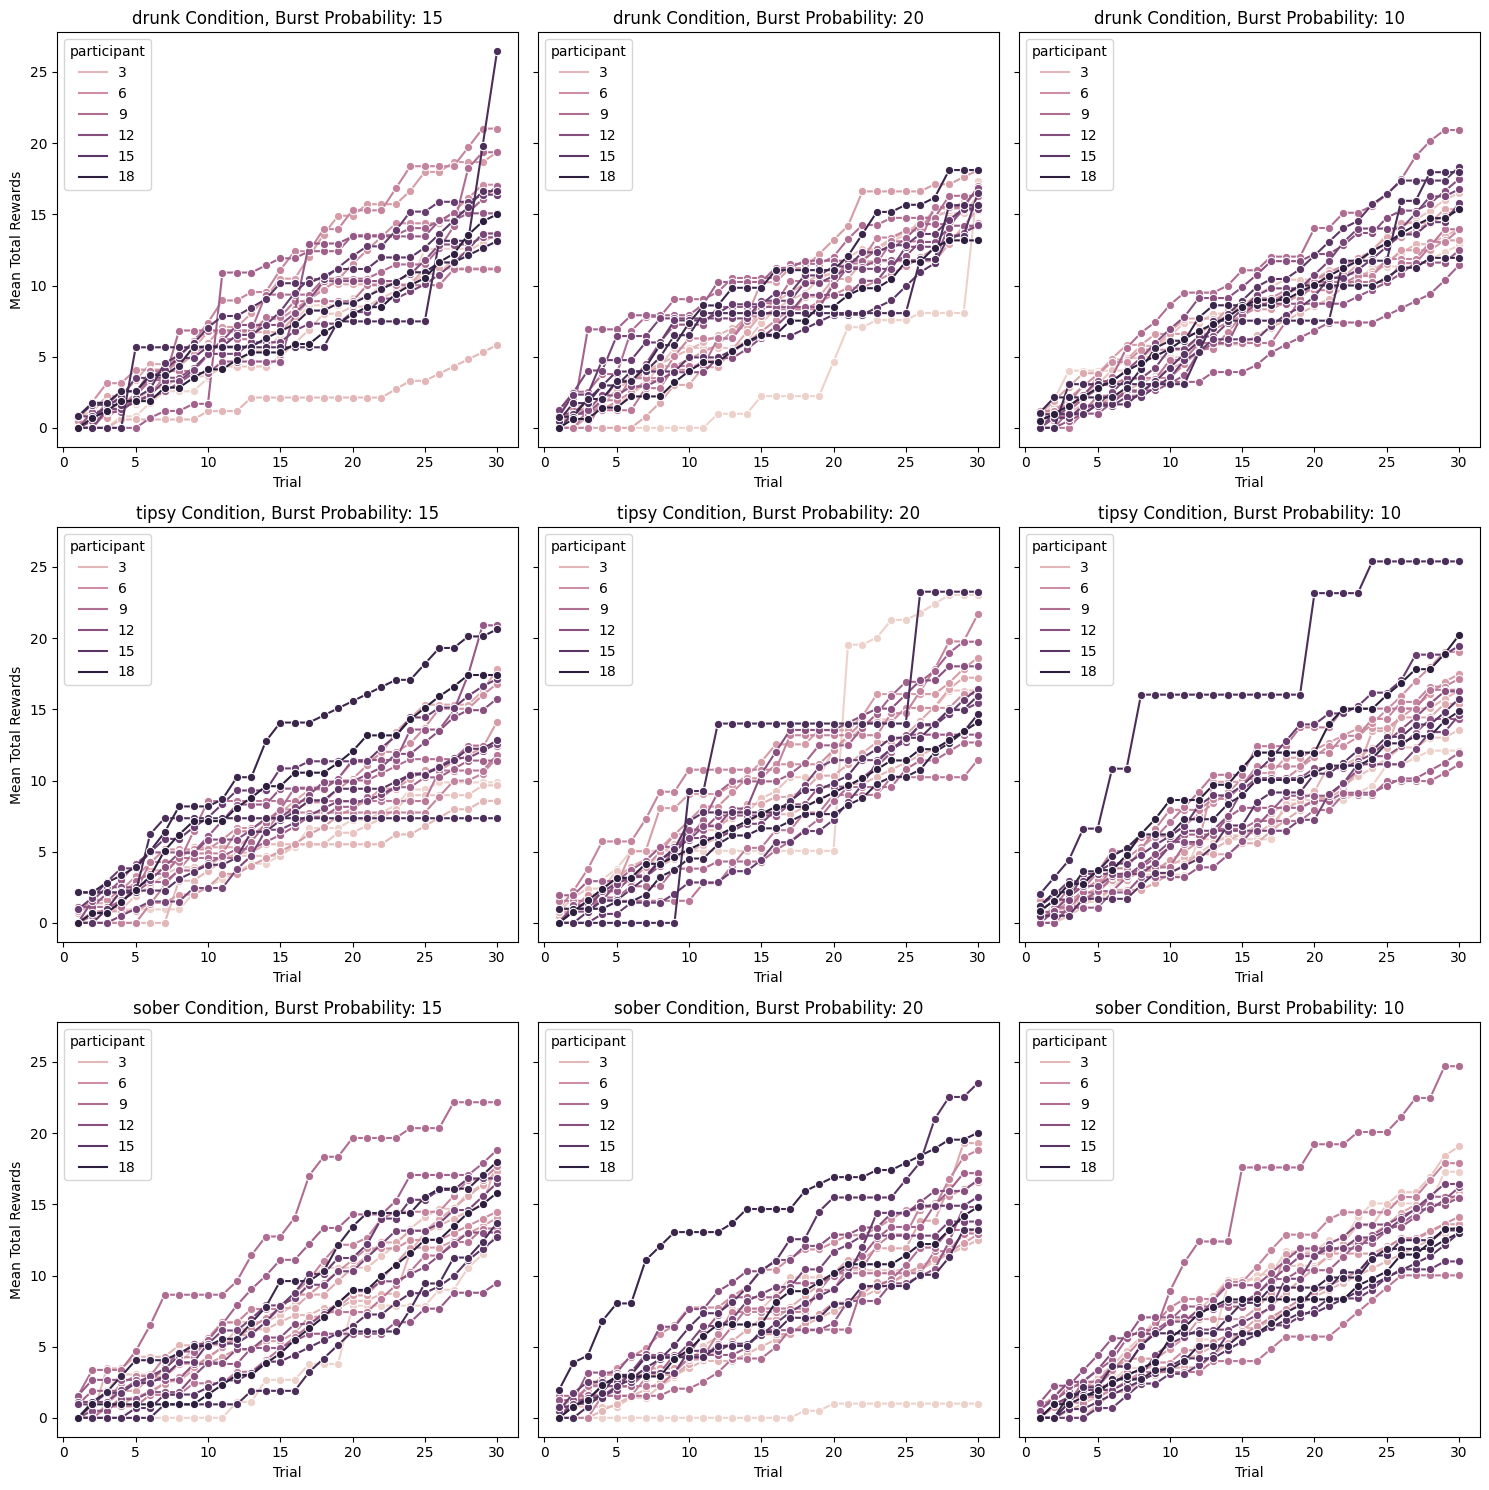

In [ ]:
avg_total_per_participant = final_df.groupby(['participant', 'condition', 'p_burst', 'trial'])['total'].mean().reset_index()

conditions = final_df['condition'].unique()
burst_probabilities = final_df['p_burst'].unique()

fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

axes = axes.flatten()

for i, condition in enumerate(conditions):
    for j, p_burst in enumerate(burst_probabilities):
        subset = avg_total_per_participant[(avg_total_per_participant['condition'] == condition) & (avg_total_per_participant['p_burst'] == p_burst)]

        subset_first_five = subset[subset['participant'].isin(range(1,19))]

        sns.lineplot(
            data=subset_first_five,
            x='trial',
            y='total',
            hue='participant',
            marker='o',
            ax=axes[i * 3 + j]
        )

        axes[i * 3 + j].set(xlabel='Trial', ylabel='Mean Total Rewards', title=f'{condition} Condition, Burst Probability: {p_burst}')

plt.tight_layout()
plt.show()

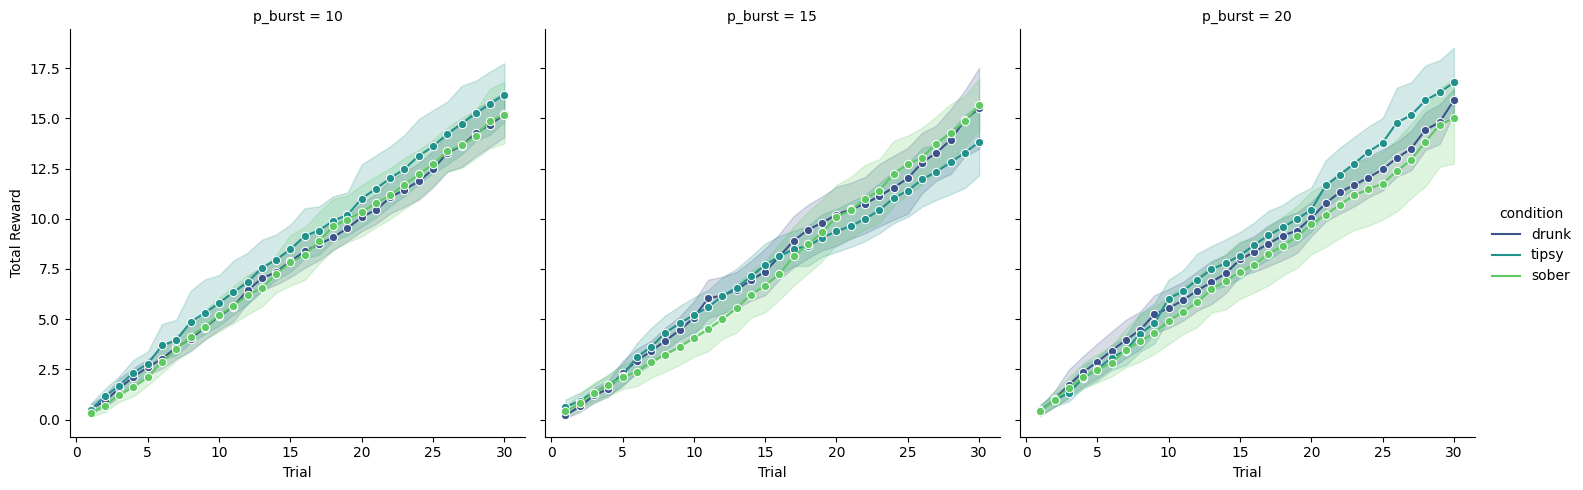

In [ ]:
g = sns.relplot(
    data=final_df,
    x='trial',
    y='total',
    col='p_burst',
    hue='condition',
    kind='line',
    palette='viridis',
    estimator='mean',
    height=5,
    marker='o'
)

g.set_axis_labels('Trial', 'Total Reward')
plt.show()

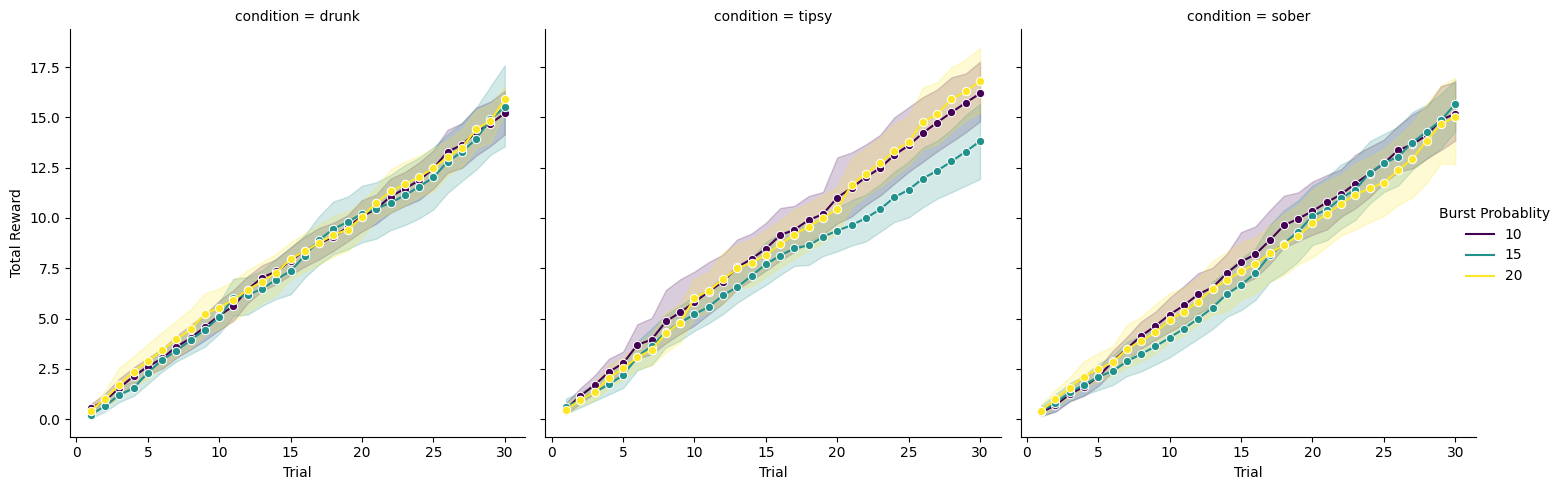

In [ ]:
g = sns.relplot(
    data=final_df,
    x='trial',
    y='total',
    col='condition',
    hue='p_burst',
    kind='line',
    palette='viridis',
    estimator='mean',
    height=5,
    marker='o'
)

g.set_axis_labels('Trial', 'Total Reward')
g.legend.set_title('Burst Probablity')
plt.show()


**TASK 9 (5 pts):** Compute the grand average of total score patterns across all `participant` x `condition` x `p_burst` conditions as a vector of 30 values. Then, for each of those three variables stratify for one of them and compute similar vectors for each value of the stratified variable. In other words, take each `participant` and average across `condition` and `p_burst`; take each `condition` and average across `participant` and `p_burst`; and finally for `p_burst` take each probability value and average across `participant` and `condition`. Find an appropriate way to store these values for **TASK 10** below.

*Hint:* Wide-form data may be useful here, try using pandas' `pivot`. I found keeping all such vectors as columns concatenated into a dataframe of size (30 rows as trials, and (3 `p_burst` + 3 `condition` + 18 `participant`)=24 columns). If you find another way that you feel comfortable, that's also okay.

We define each colimn one by one, then we concatenate them together

In [ ]:
grand_average = final_df.groupby('trial')['total'].mean()

participant_vectors = final_df.pivot_table(index='trial', columns='participant', values='total', aggfunc='mean')
condition_vectors = final_df.pivot_table(index='trial', columns='condition', values='total', aggfunc='mean')
p_burst_vectors =  final_df.pivot_table(index='trial', columns='p_burst', values='total', aggfunc='mean')
p_burst_vectors.columns = [0.1, 0.15, 0.20]

vectors_df = pd.concat([participant_vectors, condition_vectors, p_burst_vectors], axis=1)

print(vectors_df.shape)  # 30 rows as trials, and (3 p_burst + 3 condition + 18 participant)=24 columns
print(vectors_df.head(5))

(30, 24)
              1         2         3         4         5         6         7  \
trial                                                                         
1      0.000000  0.368889  0.230000  0.271111  0.423333  0.347778  0.485556   
2      0.386667  0.970000  0.447778  0.773333  0.773333  1.091111  0.678889   
3      0.715556  1.325556  1.001111  1.387778  1.341111  1.743333  1.185556   
4      1.142222  1.755556  1.402222  1.796667  1.793333  2.165556  2.082222   
5      1.348889  2.297778  1.858889  2.284444  2.494444  2.807778  2.403333   

              8         9        10        11        12        13        14  \
trial                                                                         
1      0.528889  0.578889  0.758889  0.663333  0.143333  0.347778  0.653333   
2      0.771111  1.182222  0.988889  1.182222  0.931111  1.014444  1.138889   
3      1.547778  1.557778  1.977778  1.677778  1.527778  1.388889  1.624444   
4      1.666667  2.161111  2.261111  2.177

**TASK 10 (5 pts):** Compute the mean squared deviation from the grand mean you computed above. Do this for each variable, and find the most deviant participant, most deviant condition and most deviant burst probability. Plot trial-score vectors for each of the three variable, and mark the line for most deviant value with a different color. Don't forget the grand mean for comparison. If you're not sure what to do here consult the tidy-data notebook for an example.

*Hint:* The score, $S = \sum_{i=1}^{N}(x_i - \overline{x}_i)^2 / N$ where $\overline{x}_i$ is the $i^{th}$ trial value from the grand mean, and $x_i$ is the value for that trial, for which the deviance score is being computed for, and $N=30$. You can use numpy `np.mean` and `np.square`, but be careful with your vector algebra, if you subtract a $(N,1)$ vector from a $(N,)$ one your result will be misleading, and there'll be no computation error!

In [ ]:
def mean_squared_deviation(x):
    grand_mean = x.mean()
    return np.mean(np.square(x - grand_mean))

scores = vectors_df.apply(mean_squared_deviation, axis=0)

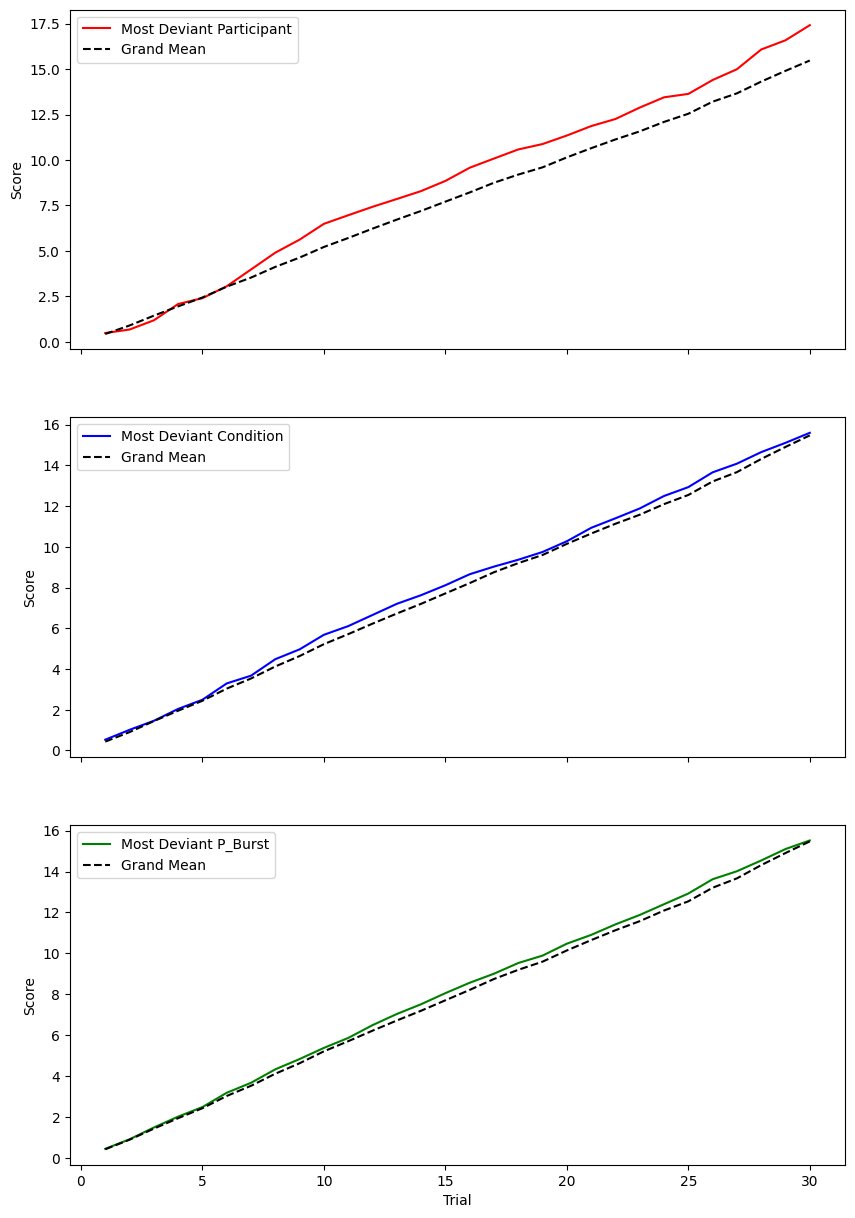

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

vectors_df[scores[:18].idxmax()].plot(ax=axes[0], label='Most Deviant Participant', color='red')

vectors_df[scores[19:22].idxmax()].plot(ax=axes[2], label='Most Deviant P_Burst', color='green')

vectors_df[scores[18:21].idxmax()].plot(ax=axes[1], label='Most Deviant Condition', color='blue')

grand_average.plot(ax=axes[0], label='Grand Mean', color='black', linestyle='--')
grand_average.plot(ax=axes[1], label='Grand Mean', color='black', linestyle='--')
grand_average.plot(ax=axes[2], label='Grand Mean', color='black', linestyle='--')

axes[0].set_ylabel('Score')
axes[1].set_ylabel('Score')
axes[2].set_ylabel('Score')
axes[2].set_xlabel('Trial')

axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.show()


**TASK 11 (BONUS 5 pts):** Can you find another aspect of this data that's left unexplored? Find a *view* of this dataset that might be interesting to you. Plot that view, and comment if your expectations are met.

As I mentioned in task 6, here I did some comparison between whether the order of sessions and the conditions. Note that the condition of participants here in the boxplots is in the order of their time series (e.g participant 1 is drunk in session 1, tispy in session 2, and sober in session 3. Thus, the boxplot boxes are in this order. In this way, we can easily compare for each participant if the order of sessions have a higher effect, or if their conditions have a higher effect.

In general, we can observe that arounf 60~70% of participants seem to have an increase in the number of their pumps, and they have had an increase in their total resulting cash. While less than 40% of participants were able to have a higher cash in their sober condition, which shows more than half of the participants were less willing to take risks when sober.

At the end, I also plotted a correlation heatmap, which didn't include much unexpected information than what we already knew. For example it is not unexpected that as the p_burst increases, the number of pumps for each participant decreases, which means, they have a negative correlation.

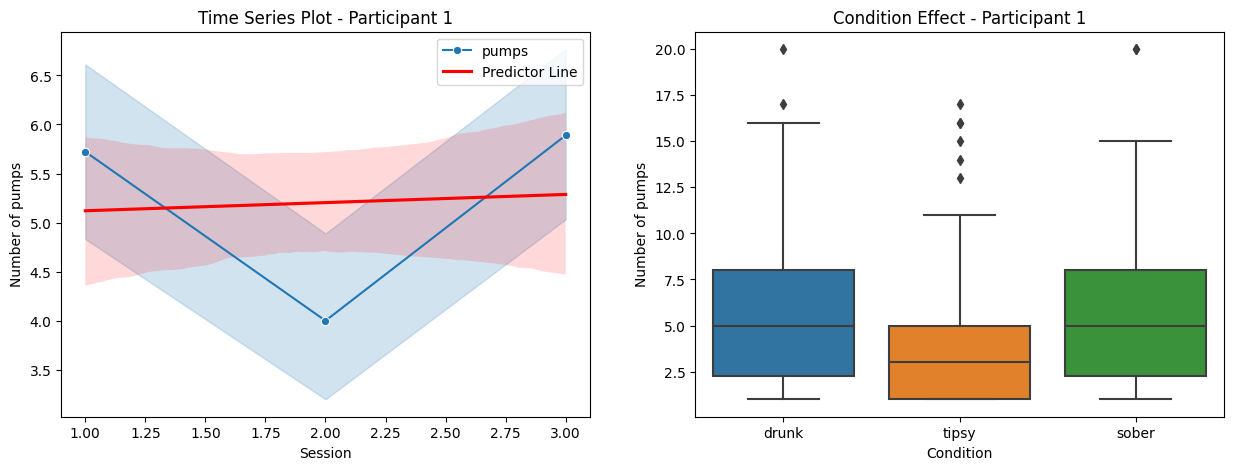

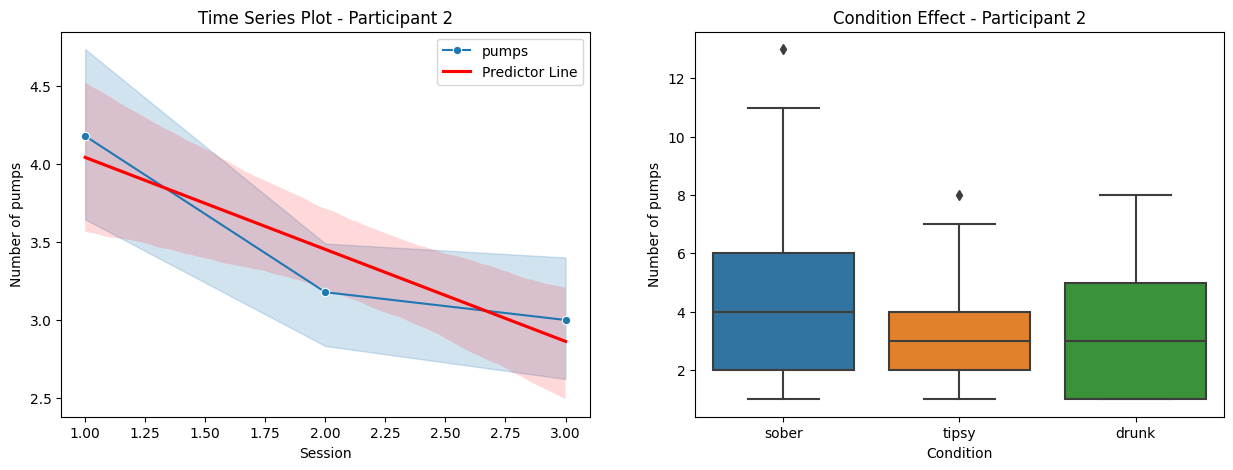

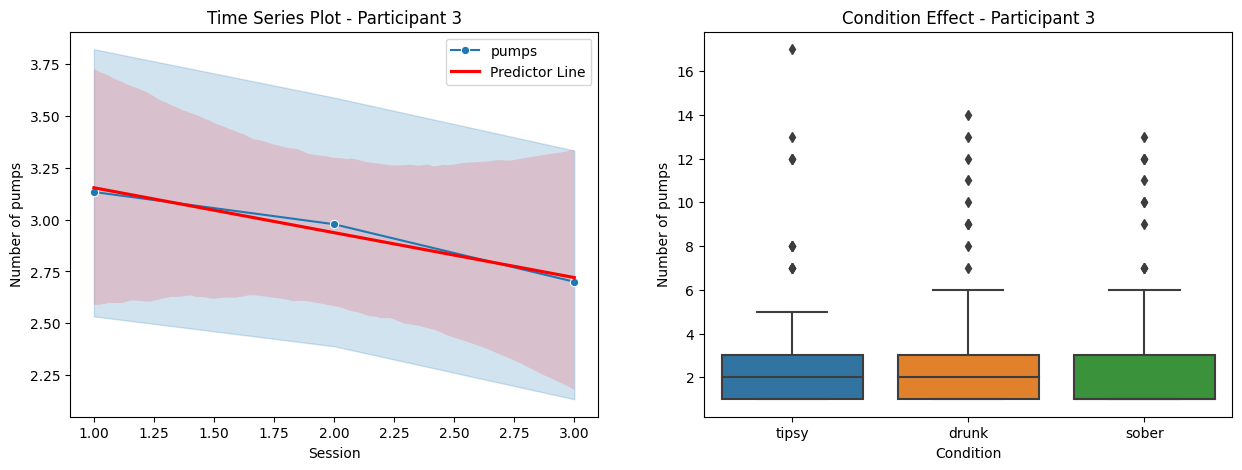

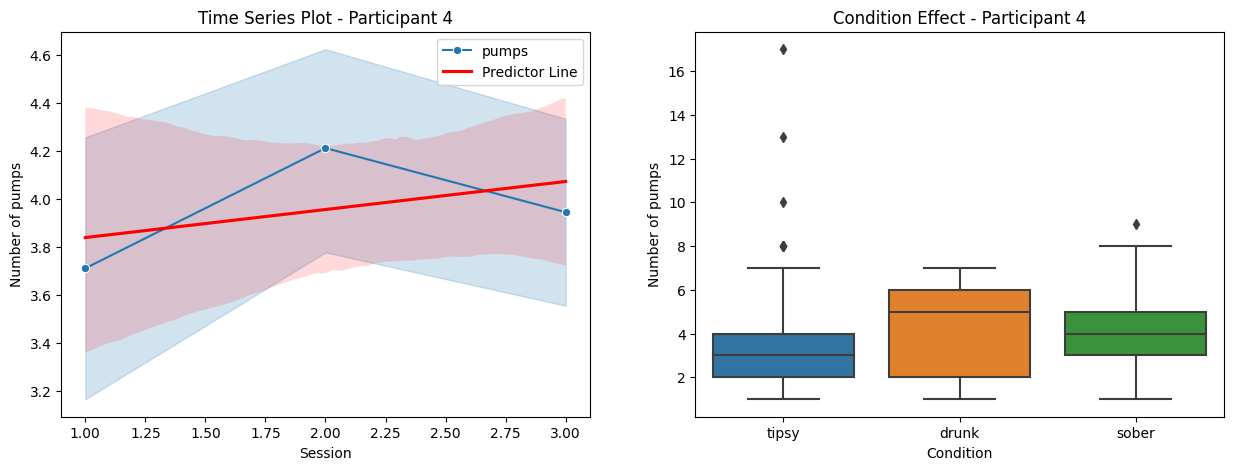

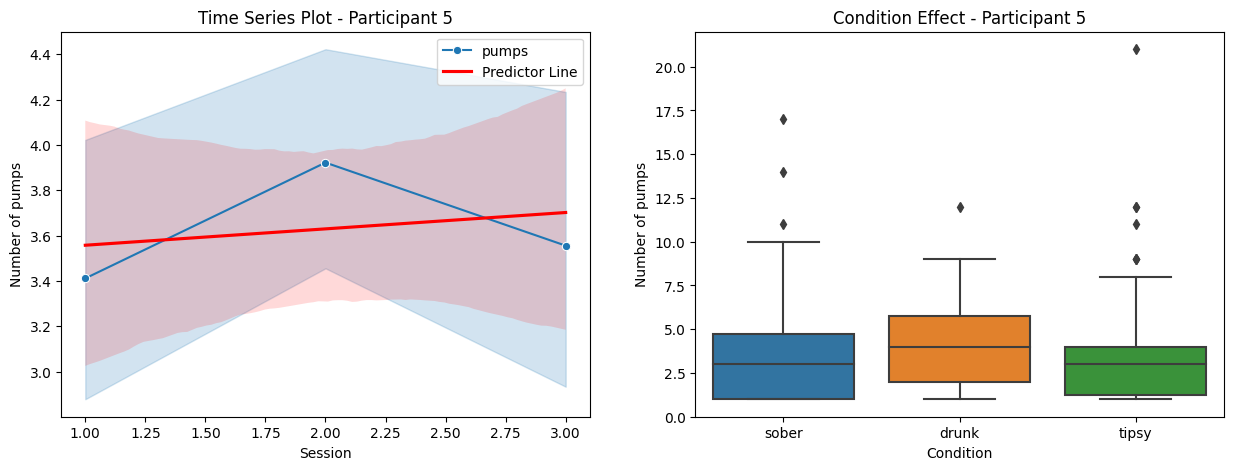

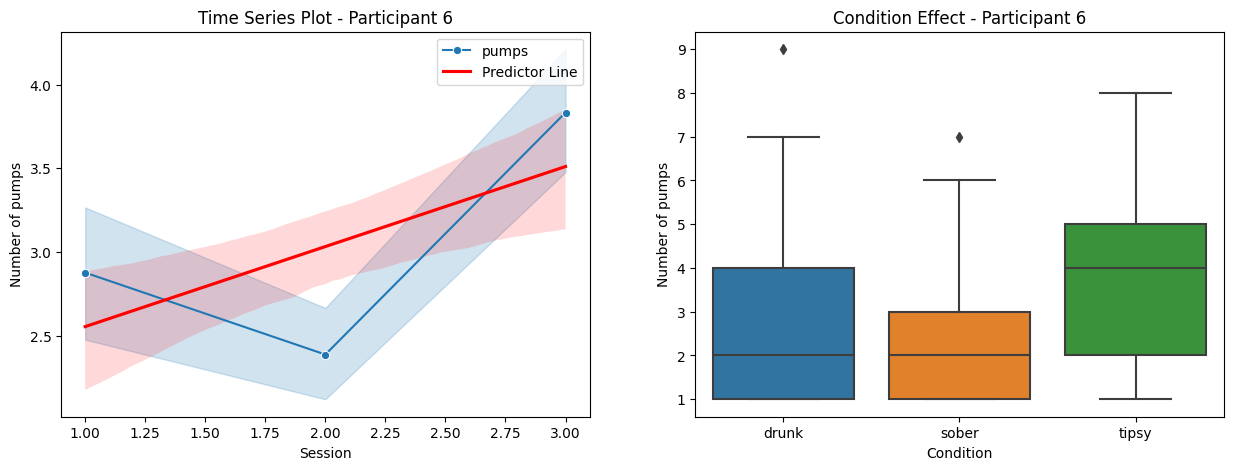

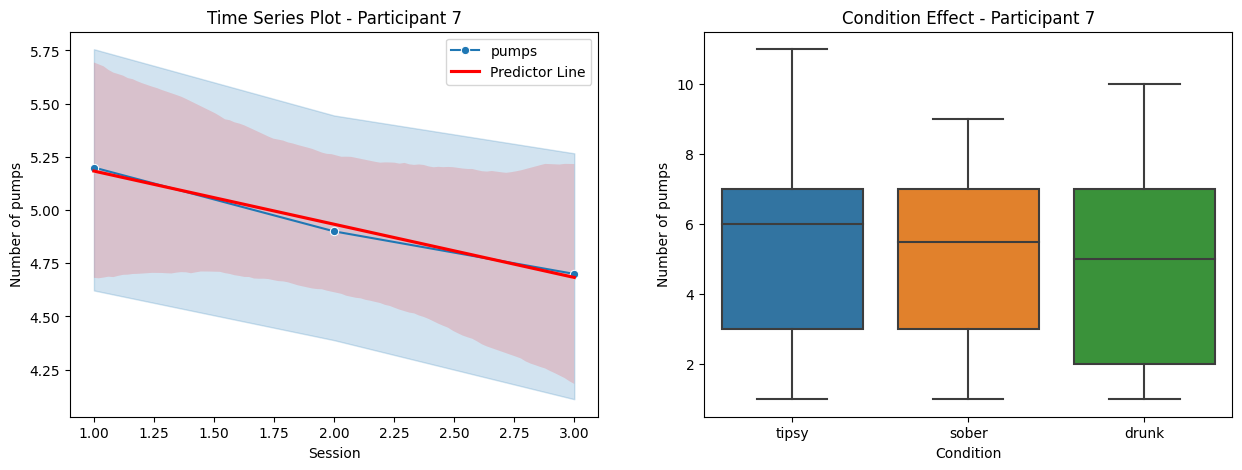

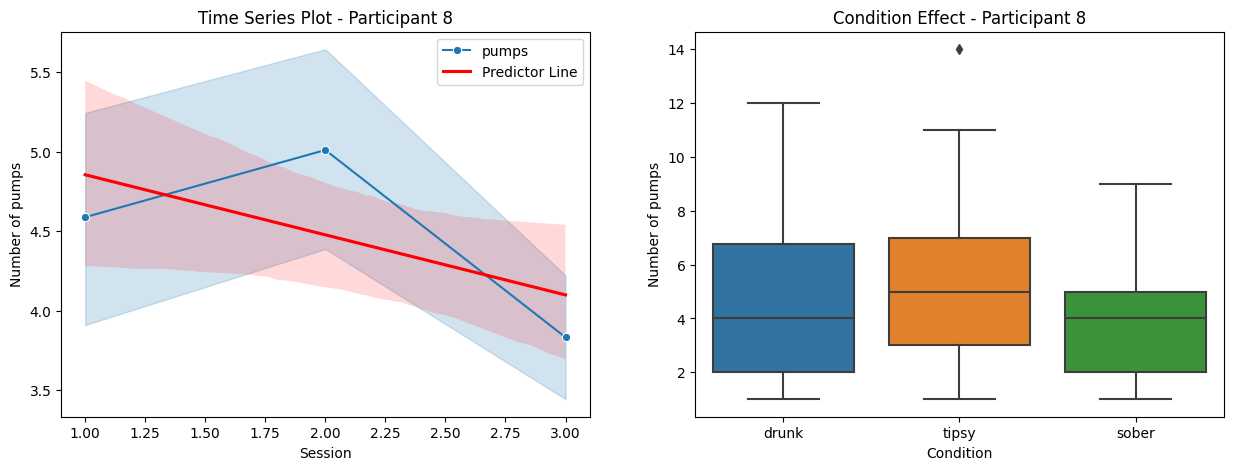

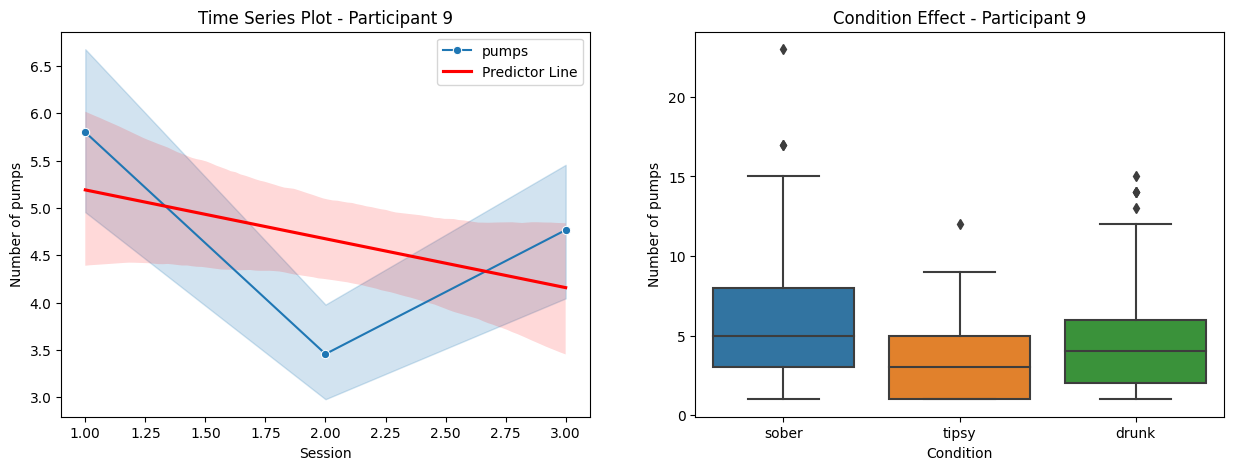

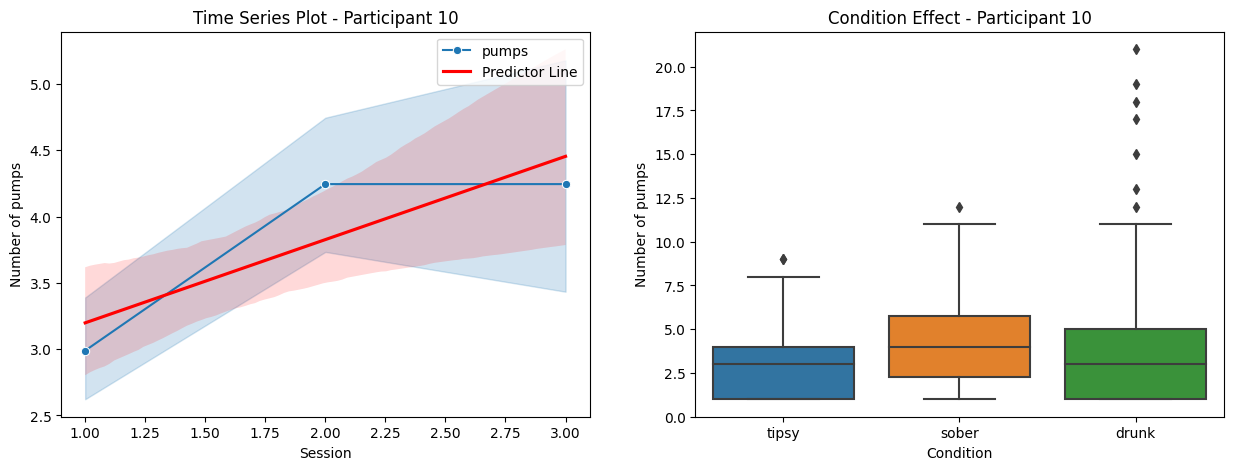

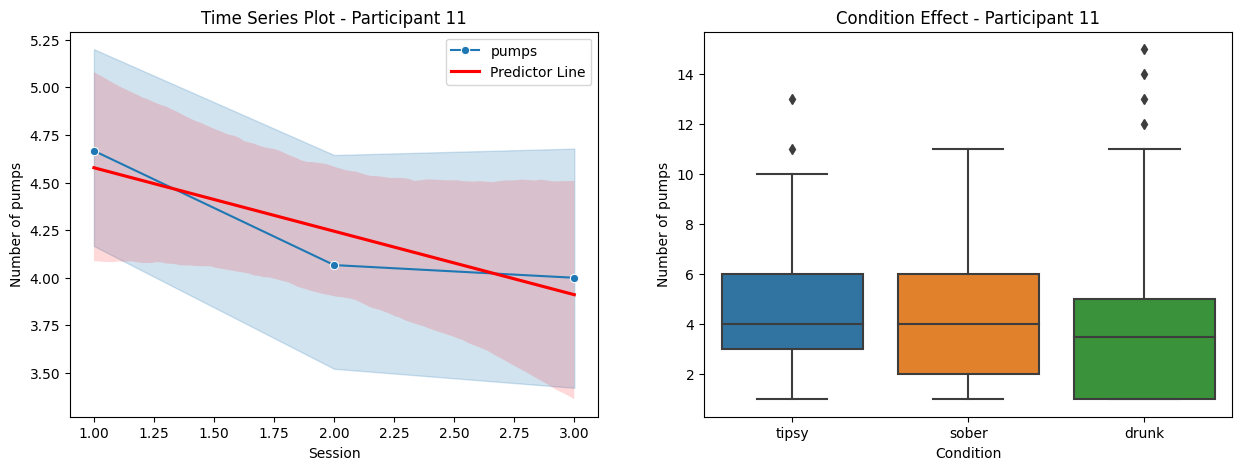

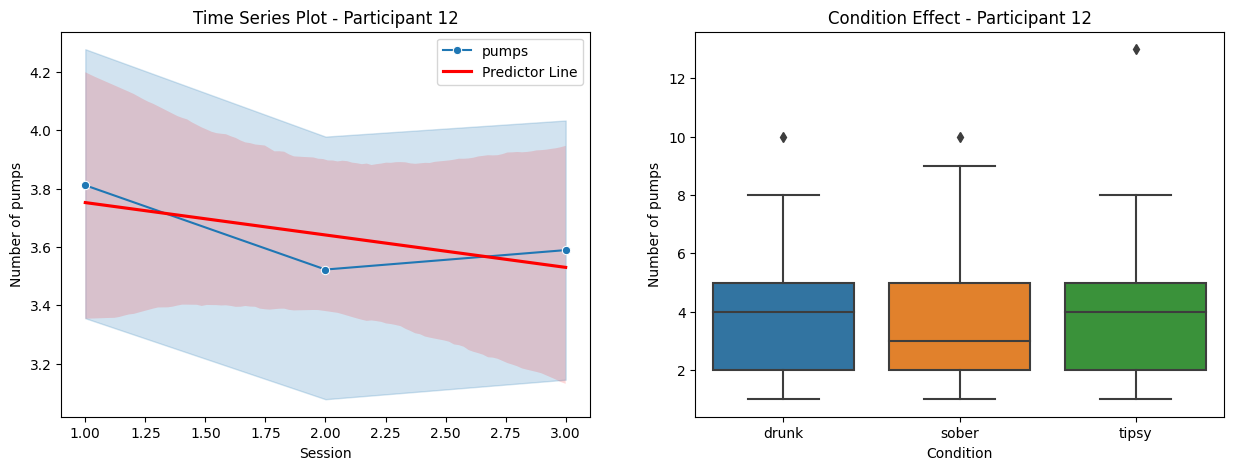

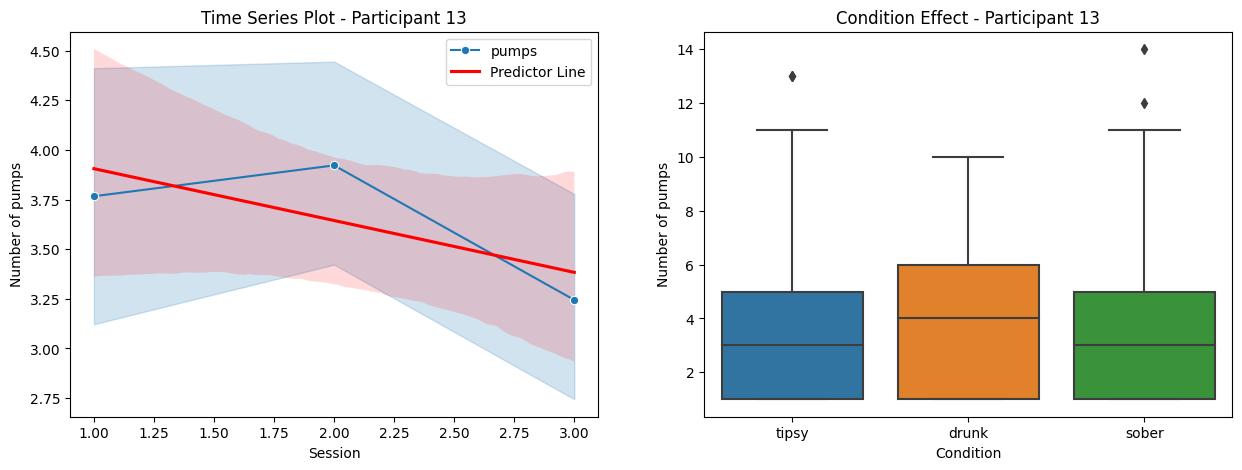

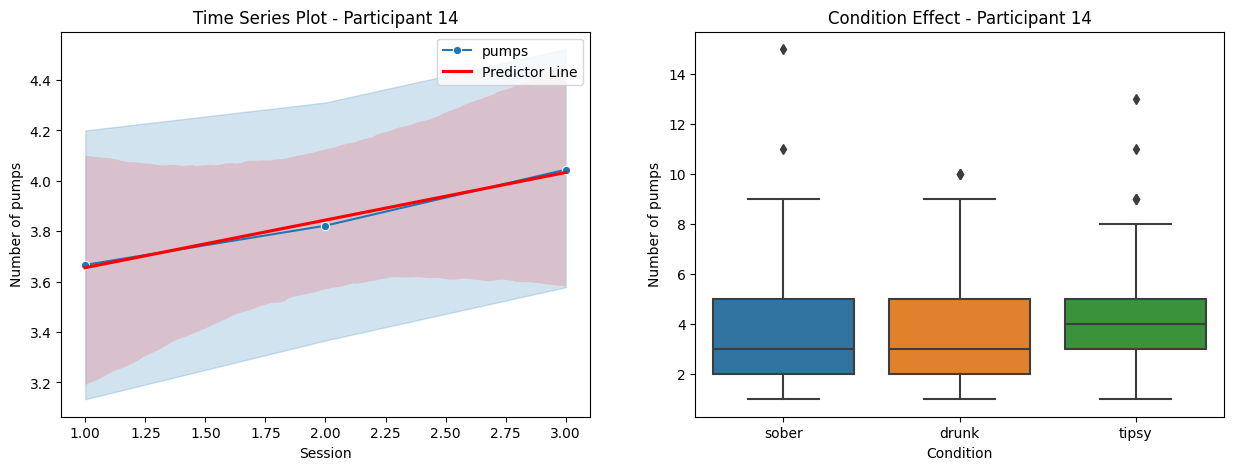

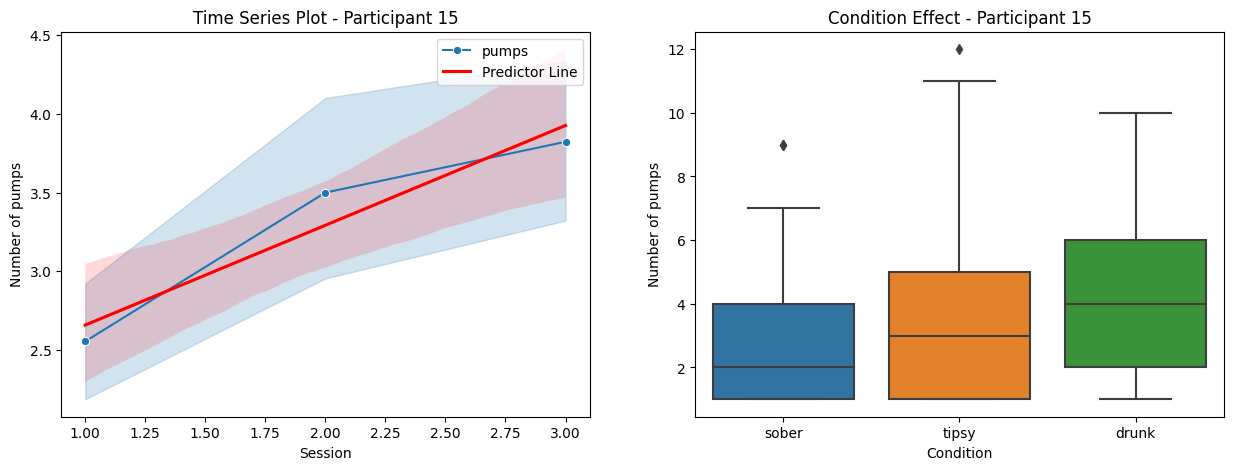

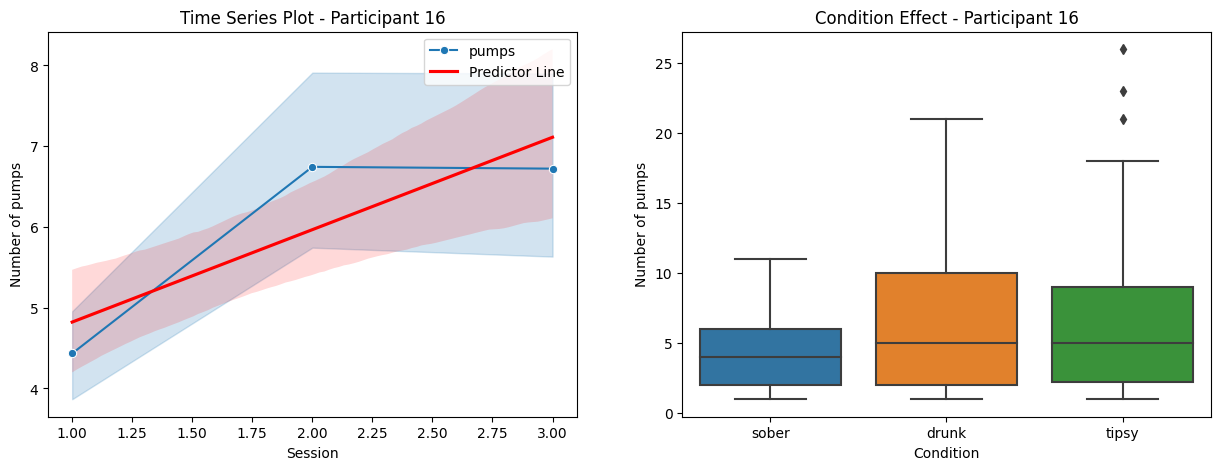

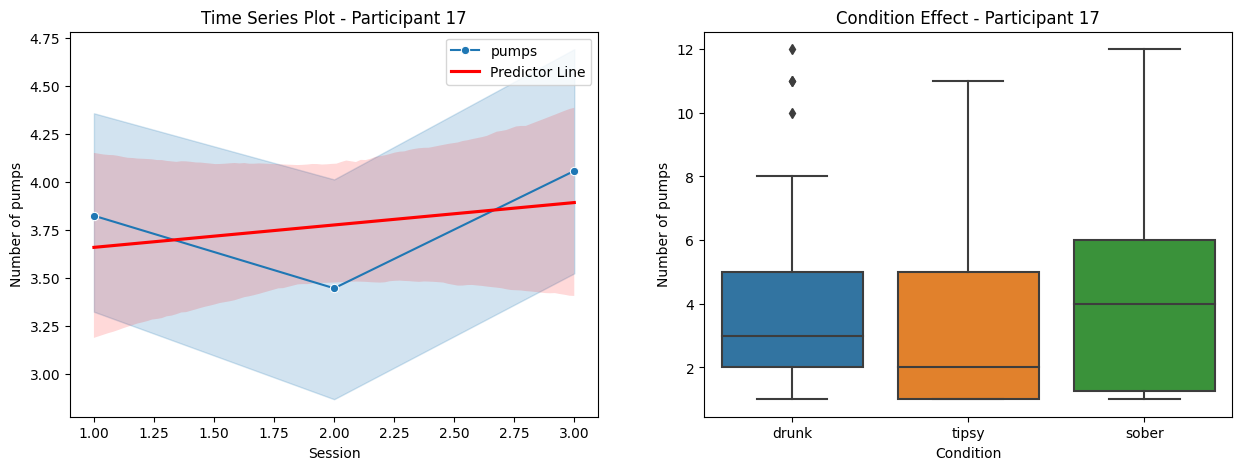

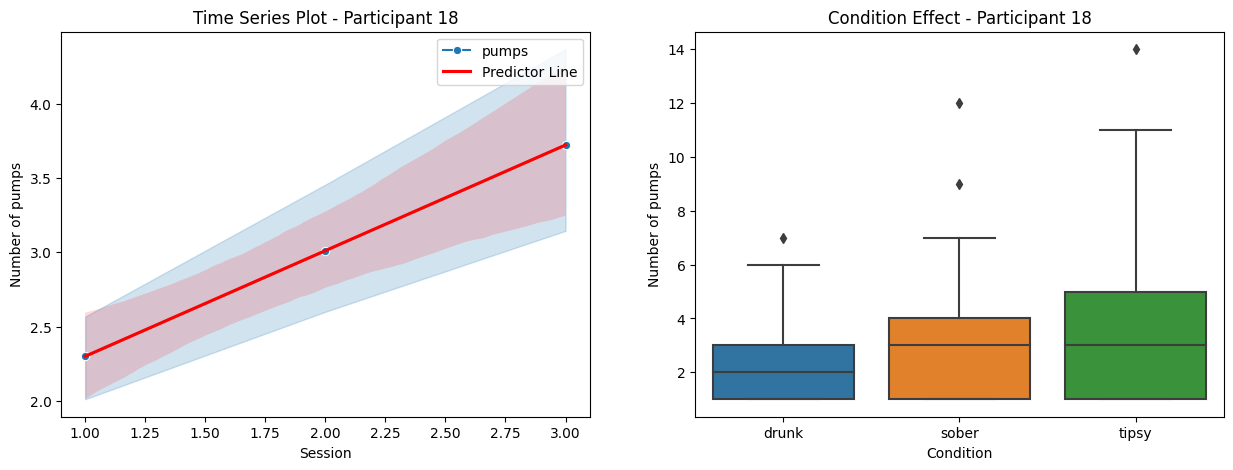

In [317]:
def compare_effects_seaborn(participant_data):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.lineplot(data=participant_data, x='session', y='pumps', estimator='mean', marker='o', label='pumps')
    sns.regplot(data=participant_data, x='session', y='pumps', scatter=False, color='r', label='Predictor Line')
    plt.xlabel('Session')
    plt.ylabel('Number of pumps')
    plt.title(f'Time Series Plot - Participant {participant_data["participant"].iloc[0]}')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(x='condition', y='pumps', data=participant_data)
    plt.xlabel('Condition')
    plt.ylabel('Number of pumps')
    plt.title(f'Condition Effect - Participant {participant_data["participant"].iloc[0]}')

    plt.show()

for _, participant_data in final_df.groupby('participant'):
    compare_effects_seaborn(participant_data)


In [ ]:
se_1 = final_df[final_df['session'] == 1]
se_3 = final_df[final_df['session'] == 3]

sober_condition = final_df[final_df['condition'] == 'sober']
drunk_condition = final_df[final_df['condition'] == 'drunk']

high_avg_pumps_ses_3 = se_3.groupby('participant')['pumps'].mean() > se_1.groupby('participant')['pumps'].mean()

high_avg_pumps_sober = sober_condition.groupby('participant')['pumps'].mean() > drunk_condition.groupby('participant')['pumps'].mean()

num_high_pumps_session_3 = high_avg_pumps_ses_3.sum()
num_high_pumps_sober = high_avg_pumps_sober.sum()

print("Number of participants with a higher average pumps in the 3rd session compared to the 1st session:", num_high_pumps_session_3)
print("Number of participants with a higher average pumps in the sober condition compared to the drunk condition:", num_high_pumps_sober)


Number of participants with a higher average pumps in the 3rd session compared to the 1st session: 10
Number of participants with a higher average pumps in the sober condition compared to the drunk condition: 7


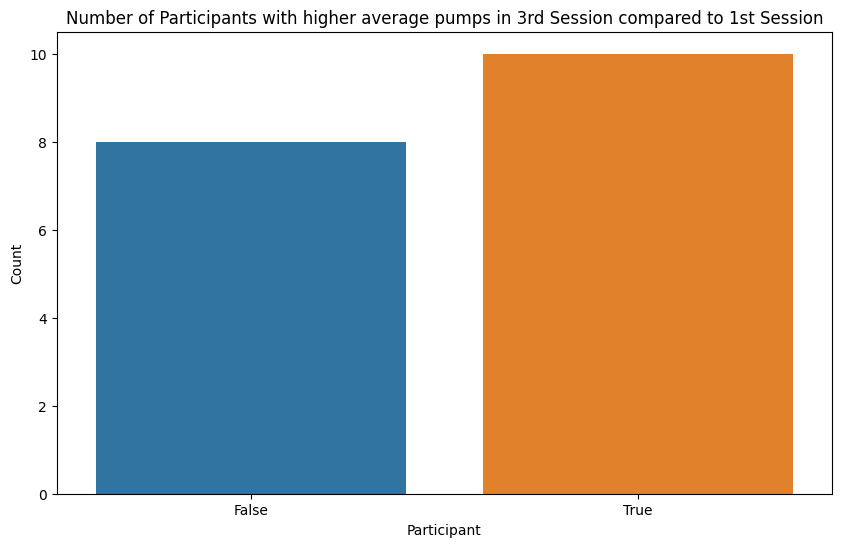

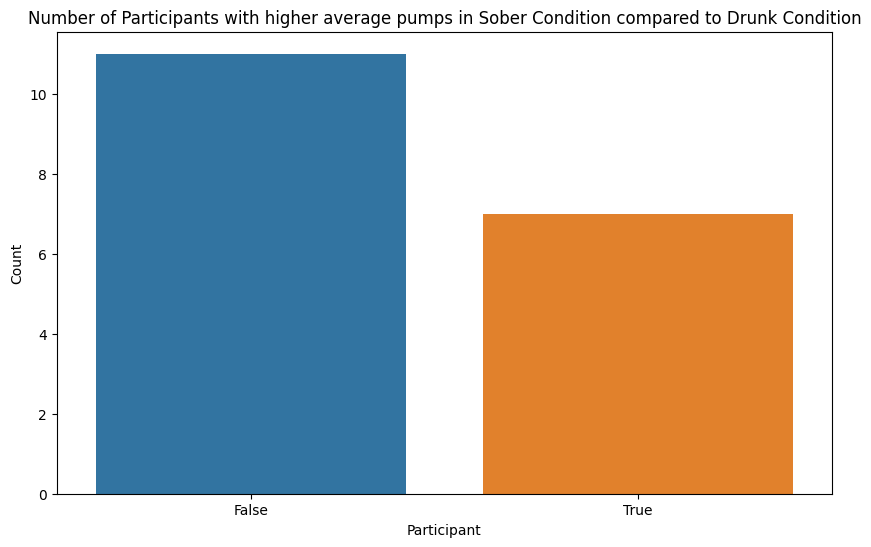

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=high_avg_pumps_ses_3.index, data=high_avg_pumps_ses_3)
plt.title('Number of Participants with higher average pumps in 3rd Session compared to 1st Session')
plt.xlabel('Participant')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x=high_avg_pumps_sober.index, data=high_avg_pumps_sober)
plt.title('Number of Participants with higher average pumps in Sober Condition compared to Drunk Condition')
plt.xlabel('Participant')
plt.ylabel('Count')
plt.show()

<ipython-input-28-a5b8e2486f4d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = final_df.corr()


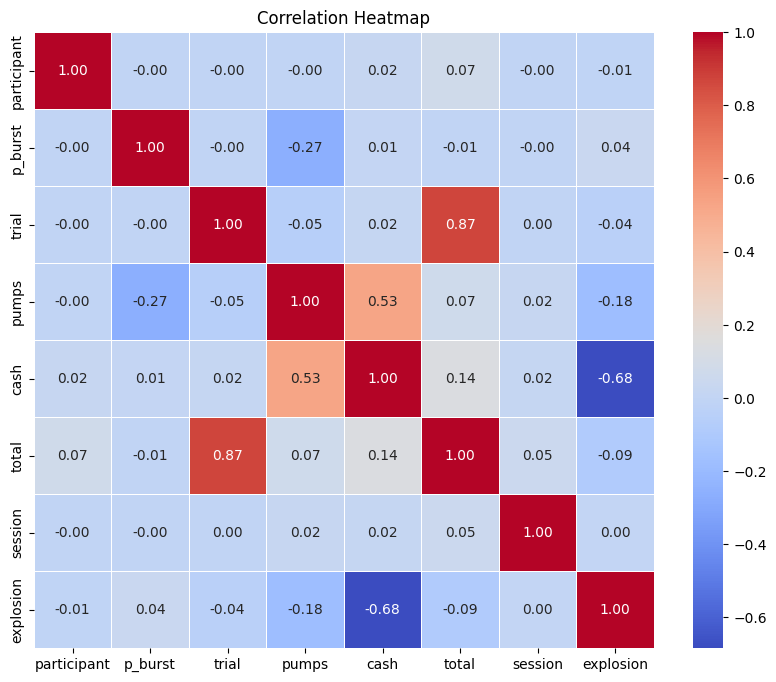

In [ ]:
corr_matrix = final_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Part 2 (50 pts)

**TASK 12 (25 pts):**

This experiment is from van Ravenzwaaij et al. (2011) [full paper available here](https://osf.io/z7e8m/download). Conduct a short literature review on BART and its use in research. What are some other experimental designs that find interesting? Select one experimental design and shortly summarize the study, and why you find it interesting.

Your summary should describe the aim/hypothesis of the study, the experimental design, and the results in one page (not exceeding 500 words.).(5 bonus points if you find a paper that is not described in other student's submissions).

If you have an idea, and can't find a study for that explain it here and describe how you'd conduct an experiment. (5 bonus points for original ideas.)

Here, I will explain a recent study on BART by [Gentili (2014)](https://www.sciencedirect.com/science/article/pii/S0166432819306679?casa_token=_DHMz_DqJBQAAAAA:09Lf4BUWJ3hMrvAddBI9NAOT1pWX5j2uTd0llCKbCgihIy_kJIBu63040Xt2ls5z6NO2qT8Iog#sec0095) which I found particularly noteworthy, as it defines a unique approach to traditional studies on BART. At the end of this essay, I will also provide my own personal idea of how this study might be extended and improved.

[Previous studies](https://www.sciencedirect.com/science/article/pii/S1053811908006927) have already evaluated the neural correlates of BART performance and the resting state functional connectivity related to BART performance. However, some studies have recently showed how using multiple fMRI resting state metrics result in a more detailed description of brain correlates of psychological traits.

With the same assumption in mind, [Gentili (2014)](https://www.sciencedirect.com/science/article/pii/S0166432819306679?casa_token=_DHMz_DqJBQAAAAA:09Lf4BUWJ3hMrvAddBI9NAOT1pWX5j2uTd0llCKbCgihIy_kJIBu63040Xt2ls5z6NO2qT8Iog#sec0095) assess in the current paper whether BART performance can be predicted on the basis of multiple resting state metrics and prior to any exposure to the BART itself. This study stands out as the first to assess resting state activity immediately before the BART, eliminating any task or anticipation effects on resting state and suggesting the potential to predict impulsivity before impulsive actions occur. The studies' aim is to determine if BART performance can be predicted based on these resting state metrics before exposure to the task.

By incorporating a trait self-report measurement of impulsivity (BIS/BAS), the study aims to explore potential gender differences in pre-existing impulsivity traits and ascertain if BART performance correlates with BIS/BAS dimensions. All subjects completed the Romanian version of the BIS/BAS, aligning with Gray’s Reinforcement Sensitivity Theory. Then they entered for MRI. a red balloon featured on the MRI scanner screen. Subjects could inflate the balloon with a left handheld button and bank gains with a right handheld button. Each run presented three blocks of ten balloons. Subjects received instructions on BART execution within the scanner, and awareness of the task type and cash reward occurred just before BART commencement, ensuring no anticipation during resting-state acquisition. The fMRI signal was acquired during BART execution.

The study underscores the importance of employing multiple resting state metrics to delineate correlates of psychological dimensions. Furthermore, it posits that behavioral facets tied to impulsivity correlate with the brain's resting-state functional architecture, allowing predictions through the study of resting-state brain activity. This revelation, indicating stable neuronal correlates of behavioral traits independent of mental states, holds significance for understanding the neurobiological foundations of personality.

My proposition for enhancing this study builds upon a recent investigation by [Sveinsdóttir (2023)](https://pubmed.ncbi.nlm.nih.gov/37887657/), providing insights on the interplay of parasympathetic activity in the BART model. The study revealed that participants with a heightened Positive Affect (PA) exhibited a more robust relaxation response in their nervous system compared to those with a less positive disposition. Echoing the concepts explored by [Chuang (2014)](https://www.sciencedirect.com/science/article/pii/S0197458013006477?via%3Dihub), a connection exists between cardiovascular risk factors and functional brain activation in adults. Notably, individuals with elevated cardiovascular risk manifest increased task-related activation in the left inferior parietal region. Leveraging this insight, we can formulate a study design that incorporates measurements of both parasympathetic activity and fMRI scans of the participants and aim to bridge the gap between

**TASK 13 (25 pts):**

Ravenzwaaij et al. (2011) model the decision behavior with a model with two parameters: $\gamma$, the risk taking propensity and $\beta$, the behavioral consistency in their paper [full paper available here](https://osf.io/z7e8m/download). They use these parameters to see if there's an effect of alcohol or session of the task on risk taking. Details of the modeling study is not introduced in class yet but note that this is a Bayesian model which can be implemented in PyMC.

A description of Ravenzwaaij et al.'s model is shown at the end of this notebook.

Are there any other probabilistic/Bayesian BART models apart from this model?. Find a different model and summarize it here using the modelling notation and verbal description of the model's aim and parameters. Shortly discuss how it's different from the two-parameter model.

[The paper available here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10194091/)

$$
\gamma: \text{Propensity for risk taking}
$$
$$
\phi: \text{Prior belief of the balloon not bursting}
$$
$$
\eta: \text{Learning rates based on the results of each trial}
$$
$$
\tau: \text{Inverse temperature quantifying the degree of determination of choices}
$$
$$
{p}^{\text{burst}}_k = 1 - \frac{\phi + \eta \sum_{i=0}^{k-1} \text{n}^{\text{success}}_i}{1 + \eta \sum_{i=0}^{k-1} \text{n}^{\text{pump}}_i} \; \; where: \; 0 < \phi < 1 \; , \; \eta > 0
$$
$$
v_k = \frac{-\gamma }{\ln(1 - {p}^{\text{burst}}_k)} \; \; where: \; \gamma \geq 0
$$
$$
{p}^{\text{pump}}_{kl} = \frac{1}{1 + e^{\tau(l-v_k)}} \; \; where: \; \tau \geq 0
$$

$$
\text{Likelihood of the data:}
$$
$$
p(D | \alpha, \mu, \tau, \gamma) = \prod_{k=1}^{k_{\text{last}}} \prod_{l=1}^{l^{last}_k} {{p}^{\text{pump}}_{kl} (1 - {p}^{\text{pump}}_{k,{l}^{ast}_k + 1})}^{d_k}.
$$

**In this model:**
1. **Renewal of Belief:**
   - Participants need to renew their belief about the balloon's explosion probability after each trial.
   - The constant probability that participants believe a pumping would result in the balloon explosion in trial $k$ is denoted as $p^{burst}_k$.
   - Participants update prior beliefs after the feedback on each trial using the above formula ${p}^{\text{burst}}_k$
   - In the equation:
    + $\eta \sum_{i=0}^{k-1} \text{n}^{\text{success}}_i$ refers to the sum of successful pumps up to trial $k-1$.
    + $\eta \sum_{i=0}^{k-1} \text{n}^{pumps}_i$ denotes the sum of all pumps until trial $k-1$.

2. **Optimal Pump Number:**
   - Participants can determine the optimal number of pumps before each trial.
   - The optimal pump number prior to each trial is denoted as $v_k$, determined without adjustment during BART.
   - The likelihood that participants can pump the balloon on trial \(k\) for pump \(l\), denoted as ${p}^{\text{burst}}_{kl}$, is as mentioned above.

3. The likelihood of the data $p(D|\alpha, \mu, \tau, \gamma)$ depends on the probability that participants can pump on trial $k$ for pump $l$ is ${p}^{\text{burst}}_{kl}$. The overall probability is the product of all these probabilities with one minus the probability of cash-out conditions.


**General Details:**
- The subject is assumed to be informed about the actual burst probability, and $p^{burst}$ is the belief of bursting probability for a subject.
- $k$ is the number of the trial.
- $l$ is the number of the pump within a trial.
- $p^{burst}_k$ is the constant probability that participants believe a pumping would result in the balloon explosion in trial $k$.
- $v_k$ is the optimal pump number determined prior to each trial.
- ${p}^{\text{pump}}_{kl}$ is the likelihood that participants can pump the balloon on trial $k$ for pump $l$.
- $d_k \in \{1, 0\}$ (pump, cash-in)
- $ln$ is the natural logarithm.

**The aim and comparison of this study with Ravenzwaji et al. (2011):**
- This study by Zeng et al. (2023) aimed at inspecting the significantly abnormal risky decision-making patterns of chronic pain patients and its neuro-cognitive correlates. Computational modeling findings on behavioral performance demonstrated that the chronic pain patient group exhibited significant deficits in learning during BART, tending to make decisions more randomly without deliberation.

-  Zeng et al. (2023) investigates risky decision-making patterns in chronic pain patients, utilizing computational models and neuroimaging techniques to uncover cognitive impairments associated with long-term pain responses. It introduces a computational framework that renews participants' beliefs about the balloon's explosion probability and allows for the determination of optimal pump numbers before each trial. In contrast, Ravenzwaaij et al. (2011) provides a more simplified mode, focusing on risk-taking propensity and behavioral consistency, offering a 2-parameter approach applied to the Balloon Analogue Risk Task. While both models provide insights into decision-making processes, Zeng et al. (2023) specifically addresses chronic pain-related impairments, integrating behavioral modeling and neuroimaging for a comprehensive understanding.


## Ravenzwaaij et al. (2011)'s BART model

$$ \gamma^{+}: \text{Propensity for risk taking} $$
$$ \beta: \text{Behavioral consistency} $$
$$ p: \text{Burst probability}$$
$$ \omega = -\gamma^{+} \,/\,\text{log}(1-p) $$
$$ \theta_{kj} = \frac{1} {1+e^{\beta(k-\omega)}} $$
$$ d_{kj} \sim \text{Bernoulli}(\theta_{kj}) $$
In this model:
- the subject is assumed to be informed about the actual burst probability, and $p$ is the belief of bursting probability for a subject
- $k$ is the number of the trial
- $j$ is the number of the opportunity
- $\omega$ is the number of pumps the subject considers optimal
- $\theta_{kj}$ is the probability that the subject decides to pump on the $j^{th}$ opportunity within the $k^{th}$ trial
- $\gamma^{+} \geq 0$; $\beta \geq 0$; $\omega \geq 0$
- $0 \leq p \leq 1$; $0 \leq \theta_{kj} \leq 1$
- $d_{kj} \in \{1,0\}$ (pump, cash-in)
- log is the natural logarithm, $ln$

# References

* The dataset is from van Ravenzwaaij, Dutilh, Wagenmakers (2011) Cognitive model decomposition of the BART: Assessment and application, Journal of Mathematical Psychology.
* Their data is available on [OSF](https://osf.io/u6qft/)